In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
df=pd.read_csv("C:\\Users\\balus\\Downloads\\archive (9)\\Loan_default.csv")

In [3]:
df.head(3)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1


In [4]:
# One-hot encode categorical columns
onehot_cols = ["EmploymentType", "MaritalStatus", "LoanPurpose", "Education", "HasMortgage", "HasDependents", "HasCoSigner"]
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df[onehot_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(onehot_cols), index=df.index)

In [5]:
df = df.drop(columns=onehot_cols)
df = pd.concat([df, encoded_df], axis=1)

In [6]:
# Drop ID column
df.drop('LoanID', axis=1, inplace=True)

In [7]:
# Define features and target
X = df.drop('Default', axis=1)
y = df['Default']

In [8]:
# Train-test split (before SMOTE!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### NAIVE BAYES CLASSIFIER || GaussianNB || priors=[0.5, 0.5] || 

In [9]:
#X_train.describe()

In [10]:
# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# get the Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB(priors=[0.5, 0.5]) # Create the model with equal class priors

In [12]:
# Train the model
model.fit(X_train_scaled, y_train)

GaussianNB(priors=[0.5, 0.5])

In [13]:
# Predict
y_pred_p_gaussian = model.predict(X_test_scaled)

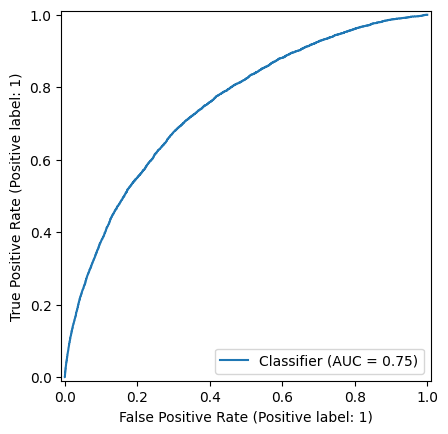

In [14]:
#Evaluate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, RocCurveDisplay)

# Predict labels and probabilities
y_proba_p_gaussian = model.predict_proba(X_test_scaled)[:, 1]  

# Metrics
accuracy = accuracy_score(y_test, y_pred_p_gaussian)
precision = precision_score(y_test, y_pred_p_gaussian)
recall = recall_score(y_test, y_pred_p_gaussian)
f1 = f1_score(y_test, y_pred_p_gaussian)
roc_auc = roc_auc_score(y_test, y_proba_p_gaussian)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_p_gaussian)
TN, FP, FN, TP = conf_matrix.ravel()

RocCurveDisplay.from_predictions(y_test, y_proba_p_gaussian)

In [15]:
print("Naive Bayes Classifier Performance:")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {roc_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Naive Bayes Classifier Performance:
Accuracy: 0.6719, Precision: 0.2183, Recall: 0.7070, AUC: 0.7499
Confusion Matrix:
 [[30121 15018]
 [ 1738  4193]]


In [16]:
# Get predicted probabilities for class 1 (defaults)
y_proba_p_gaussian_thr = model.predict_proba(X_test_scaled)[:, 1]

# Thresholds to evaluate
thresholds = [0.3, 0.5, 0.7, 0.9]

print("Threshold | Accuracy | Precision | Recall | F1 Score | TN | FP | FN | TP | roc_auc")
print("-" * 75)

for threshold in thresholds:
    y_pred_thresh_p_gaussian = (y_proba_p_gaussian_thr >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_thresh_p_gaussian)
    precision = precision_score(y_test, y_pred_thresh_p_gaussian, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh_p_gaussian)
    f1 = f1_score(y_test, y_pred_thresh_p_gaussian)
    conf_matrix = confusion_matrix(y_test, y_pred_thresh_p_gaussian)
    TN, FP, FN, TP = conf_matrix.ravel()
    roc_auc = roc_auc_score(y_test, y_proba_p_gaussian_thr)

    # Display results
    print(f"{threshold:9} | {accuracy:.4f}  | {precision:.4f}   | {recall:.4f} | {f1:.4f}   | {TN} | {FP} | {FN} | {TP} | {roc_auc}")


Threshold | Accuracy | Precision | Recall | F1 Score | TN | FP | FN | TP | roc_auc
---------------------------------------------------------------------------
      0.3 | 0.3986  | 0.1520   | 0.9128 | 0.2607   | 14944 | 30195 | 517 | 5414 | 0.7499291767822482
      0.5 | 0.6719  | 0.2183   | 0.7070 | 0.3335   | 30121 | 15018 | 1738 | 4193 | 0.7499291767822482
      0.7 | 0.8456  | 0.3398   | 0.3497 | 0.3447   | 41109 | 4030 | 3857 | 2074 | 0.7499291767822482
      0.9 | 0.8848  | 0.6885   | 0.0142 | 0.0278   | 45101 | 38 | 5847 | 84 | 0.7499291767822482


#### NAIVE BAYES CLASSIFIER || GaussianNB || SMOTE ||

In [17]:
# Apply SMOTE to training set only
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [18]:
#get the model
model = GaussianNB()

In [19]:
# Train the model
model.fit(X_train_scaled, y_train_res)

GaussianNB()

In [20]:
# Predict
y_pred_smote = model.predict(X_test_scaled)

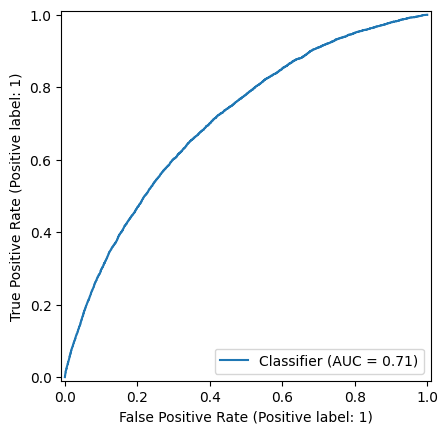

In [21]:
#Evaluate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, RocCurveDisplay)

# Predict labels and probabilities
y_proba_smote = model.predict_proba(X_test_scaled)[:, 1]  

# Metrics
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_proba_smote)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_smote)
TN, FP, FN, TP = conf_matrix.ravel()

RocCurveDisplay.from_predictions(y_test, y_proba_smote)

In [22]:
print("Naive Bayes Classifier Performance:")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {roc_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Naive Bayes Classifier Performance:
Accuracy: 0.7743, Precision: 0.2418, Recall: 0.4416, AUC: 0.7071
Confusion Matrix:
 [[36926  8213]
 [ 3312  2619]]


In [23]:
y_proba_smote = model.predict_proba(X_test_scaled)[:, 1]

# Thresholds to evaluate
thresholds = [0.3, 0.5, 0.7, 0.9]

print("Threshold | Accuracy | Precision | Recall | F1 Score | TN | FP | FN | TP | roc_auc")
print("-" * 75)

for threshold in thresholds:
    y_pred_smote = (y_proba_smote >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_smote)
    precision = precision_score(y_test, y_pred_smote, zero_division=0)
    recall = recall_score(y_test, y_pred_smote)
    f1 = f1_score(y_test, y_pred_smote)
    conf_matrix = confusion_matrix(y_test, y_pred_smote)
    TN, FP, FN, TP = conf_matrix.ravel()
    roc_auc = roc_auc_score(y_test, y_proba_smote)

    # Display results
    print(f"{threshold:9} | {accuracy:.4f}  | {precision:.4f}   | {recall:.4f} | {f1:.4f}   | {TN} | {FP} | {FN} | {TP} | {roc_auc}")


Threshold | Accuracy | Precision | Recall | F1 Score | TN | FP | FN | TP | roc_auc
---------------------------------------------------------------------------
      0.3 | 0.6302  | 0.1915   | 0.6780 | 0.2986   | 28163 | 16976 | 1910 | 4021 | 0.7070774648243752
      0.5 | 0.7743  | 0.2418   | 0.4416 | 0.3125   | 36926 | 8213 | 3312 | 2619 | 0.7070774648243752
      0.7 | 0.8550  | 0.3063   | 0.1966 | 0.2395   | 42498 | 2641 | 4765 | 1166 | 0.7070774648243752
      0.9 | 0.8837  | 0.4775   | 0.0179 | 0.0345   | 45023 | 116 | 5825 | 106 | 0.7070774648243752
